# Library imports and directory mount

In [1]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns, tensorflow as tf
import cv2, glob, os, random, sys, warnings

from google.colab import drive

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from skimage.transform import resize

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, f1_score, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore') 

sns.set() # for ploting

drive.mount('/content/gdrive')

physicalDevices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physicalDevices[0], True)

Mounted at /content/gdrive


## Configuration variables

Index | Recommended configuration
:---: | :---:
1 | Rotation up to 20º<br>shear up to 15º<br>Horizontal and vertical flip<br>Vertical and horizontal shift up to 20%<br>Zoom out up to 20%
2 | Rotation up to 15º<br>Vertical and horizontal flip<br>Image resize up to 10%

In [2]:
### Environment
csvMetadataPath = "/content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/HAM10000_metadata.csv" # "HAM10000_metadata.csv"
imagesPath = "gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/" # "images"

### Height and weight of images to be crop
h, w = 224, 224

### Model architecture
architecture = "convNeXt" # convNeXt | resNetV2 | xception
freezeLayers = False

### Transfer learning from imagenet
transferLearning = True

### Remove duplicates
removeDuplicates = True
removeNv = False
"""
0 0 10015
0 1 3310
1 0 5514
1 1 1099
"""

### Segmentation
segmentation = False

### Data augmentation
dataAugmentation = False
rotation = .45
widthShift, heightShift = .1, .1
channelShift = .15
shear = .2
zoom = .25
hFlip, vFlip = True, True
fill = 'nearest' # constant, nearest, reflect, wrap
cval = .5 # case the previous is constant
bright = [.6,1.4]

### Normalization
featureCenter = False
sampleCenter = False
featureStdNorm = False
sampleStdNorm = False
zcaWhitening = False
### Separate from imageDataGenerator
standardScalerNorm = False
minMaxScalerNorm = False

### Model configuration
epochs = 5
batchSize = 100
useCustomOptimizer = False
if removeNv:
    cancerType = {
        'akiec': 0, # 0.0 - 'Doenca de Bowens'
        'bcc': 1, # 1.0 - 'Carcinoma basocelular'
        'bkl': 2, # 2.0 - 'Keratose benigna'
        'df': 3, # 3.0 - 'Dermatofibroma'
        'vasc': 4, # 4.0 - 'Lesao vascular'
        'mel': 5, # 5.0 - 'Melanoma'
    }
    #totalImages = 1099 if removeDuplicates else 3310
else:
    cancerType = {
        'akiec': 0, # 0.0 - 'Doenca de Bowens'
        'bcc': 1, # 1.0 - 'Carcinoma basocelular'
        'bkl': 2, # 2.0 - 'Keratose benigna'
        'df': 3, # 3.0 - 'Dermatofibroma'
        'vasc': 4, # 4.0 - 'Lesao vascular'
        'mel': 5, # 5.0 - 'Melanoma'
        'nv': 6  # 6.0 - 'Nevo melanocitico'
    }
    #totalImages = 5514 if removeDuplicates else 10015
totalClasses = len(cancerType)

# Dataset import (CSV Metadata)

In [3]:
datasetMetadata = pd.read_csv(csvMetadataPath)
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization'])
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata.head()

,lesionId,imageId,cancerId
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl


In [4]:
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace = True)                       # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['duplicate'].apply(lambda x: False if x in uniqueLesions else True) # Fill the rows indicating if the lesion has a duplicated image
datasetMetadata['duplicate'].value_counts()

False    5514
True     4501
Name: duplicate, dtype: int64

Removing Duplicates

In [5]:
if removeDuplicates:
    datasetMetadata = datasetMetadata[datasetMetadata['duplicate'] == False]
if removeNv:
    datasetMetadata = datasetMetadata[datasetMetadata['cancerId'] != 'nv']
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
10,HAM_0001396,ISIC_0025276,bkl,False
15,HAM_0007207,ISIC_0031326,bkl,False
20,HAM_0006071,ISIC_0032343,bkl,False
33,HAM_0005612,ISIC_0024981,bkl,False
34,HAM_0005388,ISIC_0027815,bkl,False


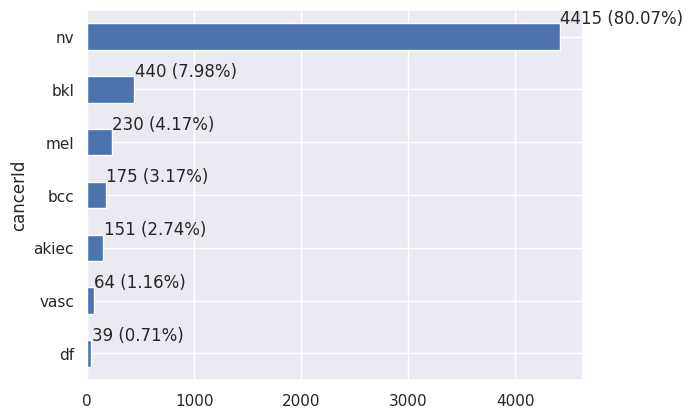

cancerId
df         39
vasc       64
akiec     151
bcc       175
mel       230
bkl       440
nv       4415
dtype: int64
Total:  5514


In [6]:
labelSize = datasetMetadata.groupby('cancerId').size().sort_values() # Sort and order every cancer class

ax = labelSize.plot.barh()

for i, v in enumerate(labelSize):
    ax.text(v + 3, i + .25, str(v) + ' (' + str(round(v/datasetMetadata.shape[0]*100, 2)) + '%)') # Set the percentage of each cancer class

plt.show()

print(labelSize)
print("Total: ", labelSize.sum())

In [7]:
datasetMetadata['cancerId'] = datasetMetadata['cancerId'].map(cancerType) # Map each class into an integer
datasetMetadata.head()

,lesionId,imageId,cancerId,duplicate
10,HAM_0001396,ISIC_0025276,2,False
15,HAM_0007207,ISIC_0031326,2,False
20,HAM_0006071,ISIC_0032343,2,False
33,HAM_0005612,ISIC_0024981,2,False
34,HAM_0005388,ISIC_0027815,2,False


# Dataset import (Imgs)

Path to the dataset images

"/content/gdrive/MyDrive/PUC/TCC/Datasets/ham10000/imgs/<imgId>.jpg"

In [8]:
images = []
loadedImages = 0

for index, row in datasetMetadata.iterrows():
    img = cv2.imread(imagesPath + row['imageId'] + '.jpg') # Collect the image from drive
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Invert color BGR => RGB
    img = cv2.resize(img, (h, w)) # Resize the image according to params provided
    images.append(img)

    loadedImages = loadedImages + 1
    if loadedImages % 1000 == 0:
        print(loadedImages)
del loadedImages

1000
2000
3000
4000
5000


5514
lesionId      HAM_0001396
imageId      ISIC_0025276
cancerId                2
duplicate           False
Name: 10, dtype: object
(224, 224, 3)


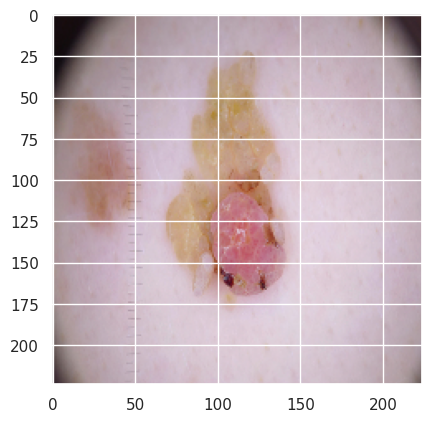

In [9]:
plt.imshow(images[0])
print(len(images))
print(datasetMetadata.iloc[0])
print(images[0].shape)
plt.show()

# Images treatment


1. Split train/val/test sets
1. Data augmentation (training set)
1. Segmentation (all sets)
1. Np array
1. Normalization (all sets, fit by training)
1. Reshape / toCategorical

Spliting in training, validation and test balancing the batches by the cancer id:

Train set = 70%

Validation set = 10%

Test set = 20%

In [10]:
XTrainVal, XTest, YTrainVal, YTest = train_test_split(images, datasetMetadata['cancerId'], test_size=0.2, train_size=0.8, stratify=datasetMetadata['cancerId'])
del images
XTrain, XVal, YTrain, YVal = train_test_split(XTrainVal, YTrainVal, test_size = 0.125, train_size = 0.875, stratify = YTrainVal)
del XTrainVal, YTrainVal

Data augmentation

Only be applied in the training set

In [11]:
if dataAugmentation: # TODO: test
    datagen = ImageDataGenerator(
        # Normalizations
        featurewise_center = featureCenter,
        samplewise_center = sampleCenter,
        featurewise_std_normalization = featureStdNorm,
        samplewise_std_normalization = sampleStdNorm,
        zca_whitening = zcaWhitening,
        # Image modifications
        rotation_range = rotation,
        zoom_range = zoom,
        channel_shift_range = channelShift,
        fill_mode = fill,
        cval = cval,
        width_shift_range = widthShift,
        height_shift_range = heightShift,
        horizontal_flip = hFlip,
        brightness_range = bright,
        shear_range = shear,
        vertical_flip = vFlip
    )

    print(XTrain.shape)
    print(XTrain.size)
    if featureCenter or featureStdNorm or zcaWhitening:
        datagen.fit(XTrain)
    print(XTrain.shape)
    print(XTrain.size)
    XTrain, YTrain, weights = datagen.flow(XTrain, YTrain, batch_size = batchSize) # TODO: review batchSize

Segmentation

In [12]:
def segmentImg(img, alpha = 0.7, kernelMask = (5, 5), kernelSoftMask = (21, 21)):
    grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    softenedImg = cv2.GaussianBlur(grayImg, kernelMask, 0) # Apply softened filter to reduce noise
    _, mask = cv2.threshold(softenedImg, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) # Thresholding algorithm to create mask
    softenedMask = cv2.GaussianBlur(mask, kernelSoftMask, 0) # Smoothing filter
    segmentedImg = cv2.bitwise_and(img, img, mask = softenedMask) # Apply mask
    beta = 1.0 - alpha  # Beta = weight for original image, alpha = Weight for segmented image - 0 for highlight only the lesion, 1 for original image
    return cv2.addWeighted(img, alpha, segmentedImg, beta, 0) # Merge segmented image and original image weighted

def segmentImgList(imgs):
    for i in range(len(imgs)):
        imgs[i] = segmentImg(imgs[i])
    return imgs

if segmentation: # TODO: test
    XTrain = segmentImgList(XTrain)
    XVal = segmentImgList(XVal)
    XTest = segmentImgList(XTest)

Transform datasets into np arrays

In [13]:
# TODO: adapt
#images = np.array(images) # Transform images list into np array
#print(images.shape)

#images = images.reshape(totalImages, h * w * 3) # 4d -> 2d
#print(images.shape)
#print(images.dtype)

In [14]:
# TODO: test
XTrain = np.array(XTrain)
XTrain = XTrain.reshape(XTrain.shape[0], h * w * 3) # 4d -> 2d

XVal = np.array(XVal)
XVal = XVal.reshape(XVal.shape[0], h * w * 3) # 4d -> 2d

XTest = np.array(XTest)
XTest = XTest.reshape(XTest.shape[0], h * w * 3) # 4d -> 2d

Normalization

In [15]:
if minMaxScalerNorm:
    minMaxScaler = MinMaxScaler()
    minMaxScaler.fit(np.asarray(XTrain))

    XTrain = minMaxScaler.transform(XTrain)
    XVal = minMaxScaler.transform(XVal)
    XTest = minMaxScaler.transform(XTest)
elif standardScalerNorm:
    standardScaler = StandardScaler()
    standardScaler.fit(np.asarray(XTrain))

    XTrain = standardScaler.transform(XTrain)
    XVal = standardScaler.transform(XVal)
    XTest = standardScaler.transform(XTest)

print(np.shape(XTest))
print(np.shape(XTrain))
print(np.shape(XVal))
print(YTrain.head())

(1103, 150528)
(3859, 150528)
(552, 150528)
6372    6
8409    6
2437    4
4300    6
1952    5
Name: cancerId, dtype: int64


Resize

In [16]:
print(XTrain.shape[0])
print(XVal.shape[0])
print(XTest.shape[0])
XTrain = XTrain.reshape(XTrain.shape[0], h, w, 3).astype('float32')
XVal = XVal.reshape(XVal.shape[0], h, w, 3).astype('float32')
XTest = XTest.reshape(XTest.shape[0], h, w, 3).astype('float32')

YTrain = np_utils.to_categorical(YTrain)
YVal = np_utils.to_categorical(YVal)
YTest = np_utils.to_categorical(YTest)

print(XTrain[0].shape)
XTrain.dtype

3859
552
1103
(224, 224, 3)


dtype('float32')

# Model training

Loading pre treined model

In [18]:
with tf.device('/GPU:0'): # Using GPU processing on model
    """match architecture:
        case "convNeXt":
            model = tf.keras.applications.ConvNeXtBase(weights='imagenet' if transferLearning else None, include_top=False, classes=totalClasses, input_shape=(h,w,3))
        case "resNetV2":
            model = tf.keras.applications.ResNet50V2(weights='imagenet' if transferLearning else None, include_top=False, classes=totalClasses, input_shape=(h,w,3))
        case "xception":
            model = tf.keras.applications.Xception(weights='imagenet' if transferLearning else None, include_top=False, classes=totalClasses, input_shape=(h,w,3))
        case _:
            raise Exception("model not configured or non existent")
"""
    model = tf.keras.applications.ConvNeXtBase(weights='imagenet' if transferLearning else None, include_top=False, classes=totalClasses, input_shape=(h,w,3))
    if freezeLayers:
        for layer in model.layers:
            layer.trainable = False

    prediction = tf.keras.layers.Dense(totalClasses, activation='softmax')(tf.keras.layers.Flatten()(model.output))

    model = tf.keras.Model(inputs=model.input, outputs=prediction)

    if useCustomOptimizer:
        optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics = ["accuracy"])
    else:
        model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

    learningRateReduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

350926856/350926856 [==============================] - 10s 0us/step


validation_freq = [1,3,5]

In [19]:
with tf.device('/GPU:0'):
    if dataAugmentation: # TODO: remove if and adjust inputs
        history = model.fit_generator(trainingSet,
                                    epochs = epochs, validation_data = (XVal, YVal),
                                    verbose = 2, steps_per_epoch=XTrain.shape[0] // batchSize,
                                    callbacks=[learningRateReduction])
    else:
        history = model.fit(XTrain, YTrain, validation_data = (XVal, YVal), epochs=epochs, batch_size=batchSize, verbose = 2)

Epoch 1/5


ResourceExhaustedError: ignored

# Statistics

Training epochs statistics

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [ ]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.title('Model Training History')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.show()

General eficiency

In [ ]:
YPredicted = model.predict(XTest)
print('Test set evaluation: ', model.evaluate(XTest, YTest, verbose = 0))
print('Validation set evaluation: ', model.evaluate(XVal, YVal, verbose = 0))

Confusion matrix

In [ ]:
cm = confusion_matrix(YTest.argmax(axis = 1), YPredicted.argmax(axis = 1))
# TODO: adapt to 6 | 7 classes
# Melanocytic nevi
labels = ['Bowens disease', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Vascular lesion', 'Melanoma', 'Melanocytic nevi']
dfCm = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (12, 12))
sns.set(font_scale = 1.4) # Label size
sns.heatmap(dfCm, annot = False, annot_kws = {"size": 12}) # Font size

for i in range(totalClasses):
    for j in range(totalClasses):
        text = plt.text(j + 0.5, i + 0.5, "{:.2f}%".format(cm[i, j] / cm[i].sum() * 100), va="center", ha="center", color="g")

ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

Metrics

In [ ]:
print("Accuracy: ", accuracy_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1)))
# TODO: format for every class
print("Precision: ", precision_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None))

print("Recall: ", recall_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None))

print("F1-score: ", f1_score(YTest.argmax(axis=1), YPredicted.argmax(axis=1), average=None))

print("ROC AUC score: ", roc_auc_score(YTest, YPredicted, average=None))

cmMulti = multilabel_confusion_matrix(YTest.argmax(axis=1),YPredicted.argmax(axis=1))
specificity = []
for i in range(len(cmMulti)):
    print('\n', cmMulti[i])
    tn = cmMulti[i][0][0]
    fp = cmMulti[i][0][1]
    specificity.append(tn / (tn + fp))
print("\nSpecificity: ", specificity)

Saving model into google drive

In [ ]:
model.save('/content/gdrive/MyDrive/PUC/TCC/Notebooks/convNext7classes.h5')